In [ ]:
#Instalacao das dependencias
!pip install medmnist kaggle --quiet
!pip install scikit-image seaborn --quiet

#Imports utils
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from pathlib import Path
from PIL import Image
from skimage import io, util
from skimage.io import imread

#Medmnist
from medmnist import OrganCMNIST, PneumoniaMNIST, DermaMNIST, INFO

#Tensorflow
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Scikit-learn
from sklearn.metrics import confusion_matrix, classification_report


In [ ]:
#Carregar imagens do MedMNIST

datasets = {
    "abdomen": OrganCMNIST(split="val", download=True, size=224),
    "chest": PneumoniaMNIST(split="val", download=True, size=224),
    "derma": DermaMNIST(split="val", download=True, size=224),
}

#Salvar como .npz
for nome, ds in datasets.items():
    np.savez(f"{nome}mnist_224.npz", val_images=ds.imgs, val_labels=ds.labels)


100%|██████████| 760M/760M [00:09<00:00, 78.5MB/s]
100%|██████████| 214M/214M [00:04<00:00, 53.3MB/s]
100%|██████████| 1.09G/1.09G [00:10<00:00, 103MB/s] 


In [ ]:
#Extrair 250 amostras de cada arquivo .npz e converter para png


num_samples = 250
output_dir = "imagens_png"
os.makedirs(output_dir, exist_ok=True)

datasets = {
    "chest": "chestmnist_224.npz",
    "abdomen": "abdomenmnist_224.npz",
    "derma": "dermamnist_224.npz"
}

for nome, arquivo in datasets.items():

    dataset_dir = os.path.join(output_dir, nome)
    os.makedirs(dataset_dir, exist_ok=True)

    data = np.load(arquivo)
    imagens = data["val_images"][:num_samples]

    for i, img in enumerate(imagens):
        if img.ndim == 3 and img.shape[2] == 3:
            img = np.mean(img, axis=2)
        if img.max() <= 1.0:
            img = (img * 255).astype(np.uint8)

        img_pil = Image.fromarray(img).convert("L")
        img_pil.save(os.path.join(dataset_dir, f"{nome}_{i:03d}.png"))


In [ ]:
#Montar Drive para usar o token API do kaggle para carregar as imagens

from google.colab import drive
drive.mount('/content/drive')

#Mover kaggle.json

kaggle_json_path = '/content/drive/MyDrive/Colab Notebooks/kaggle.json'

#Verificar se o arquivo existe
if not os.path.exists(kaggle_json_path):
    raise FileNotFoundError(f"Arquivo kaggle.json não encontrado em {kaggle_json_path}")

os.makedirs('/root/.kaggle', exist_ok=True)

shutil.copy(kaggle_json_path, '/root/.kaggle/')

#Ajustar as permissões
!chmod 600 /root/.kaggle/kaggle.json

#Carregar o dataset do Kaggle
!kaggle datasets download -d navoneel/brain-mri-images-for-brain-tumor-detection

#Descompactar
!unzip -q brain-mri-images-for-brain-tumor-detection.zip -d brain_tumor_dataset


Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection
License(s): copyright-authors
  0% 0.00/15.1M [00:00<?, ?B/s]
100% 15.1M/15.1M [00:00<00:00, 585MB/s]


In [ ]:
#Processar e organizar imagens do kaggle

base_src_path = "brain_tumor_dataset"

#Pasta de destino unica para todas as imagens MRI (yes + no)
dest_path = "imagens_png/brain_mri"
os.makedirs(dest_path, exist_ok=True)

#Processar pastas yes e no
for classe in ["yes", "no"]:
    src_path = os.path.join(base_src_path, classe)
    imagens = glob(os.path.join(src_path, "*.jpg"))[:250]  #Limite de 250 por classe

    for i, img_path in enumerate(imagens):
        #Nome do arquivo inclui a classe para não ter conflito
        nome_img = f"{classe}_{i:03d}.png"
        img = Image.open(img_path).convert("L").resize((224, 224))
        img.save(os.path.join(dest_path, nome_img))


In [ ]:
#Aplicacao de ruido

#Diretorios
base_input_dir = "imagens_png"
base_output_dir = "dataset_reduzido"
os.makedirs(base_output_dir, exist_ok=True)

modalidades = ['abdomen', 'chest', 'derma', 'brain_mri']

#Tipos de ruido com 3 intensidades cada
noise_types = {
    'gauss': [0.001, 0.01, 0.02],
    's&p': [0.002, 0.01, 0.05],
    'speckle': [0.04, 0.07, 0.1]
}

#Funcoes de ruido
def apply_gaussian_noise(image, var):
    return util.random_noise(image, mode='gaussian', var=var)

def apply_salt_pepper_noise(image, amount):
    return util.random_noise(image, mode='s&p', amount=amount)

def apply_speckle_noise(image, var):
    noise = np.random.normal(0, np.sqrt(var), image.shape)
    noisy = image + image * noise
    return np.clip(noisy, 0, 1)

def save_image(img_array, save_path):
    img_uint8 = (img_array * 255).astype(np.uint8)
    Image.fromarray(img_uint8).save(save_path)

#Processa cada modalidade
for modalidade in modalidades:
    input_dir = os.path.join(base_input_dir, modalidade)
    output_base = os.path.join(base_output_dir, modalidade)
    os.makedirs(os.path.join(output_base, "sem_ruido"), exist_ok=True)

    arquivos = sorted([f for f in os.listdir(input_dir) if f.lower().endswith('.png')])[:250]

    for nome in arquivos:
        caminho_imagem = os.path.join(input_dir, nome)
        image = io.imread(caminho_imagem) / 255.0

        #Salvar original
        save_image(image, os.path.join(output_base, "sem_ruido", nome))

        #Aplicar ruidos
        for noise_type, intensities in noise_types.items():
            for i, intensity in enumerate(intensities):
                if noise_type == 'gauss':
                    noisy = apply_gaussian_noise(image, var=intensity)
                    pasta = f"gauss_{i}"
                elif noise_type == 's&p':
                    noisy = apply_salt_pepper_noise(image, amount=intensity)
                    pasta = f"sp_{i}"
                elif noise_type == 'speckle':
                    noisy = apply_speckle_noise(image, var=intensity)
                    pasta = f"speckle_{i}"

                save_dir = os.path.join(output_base, modalidade, pasta)
                os.makedirs(save_dir, exist_ok=True)
                save_image(noisy, os.path.join(save_dir, nome))


/tmp/ipython-input-19-494368672.py:36: UserWarning: Glyph 128165 (\N{COLLISION SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128165 (\N{COLLISION SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


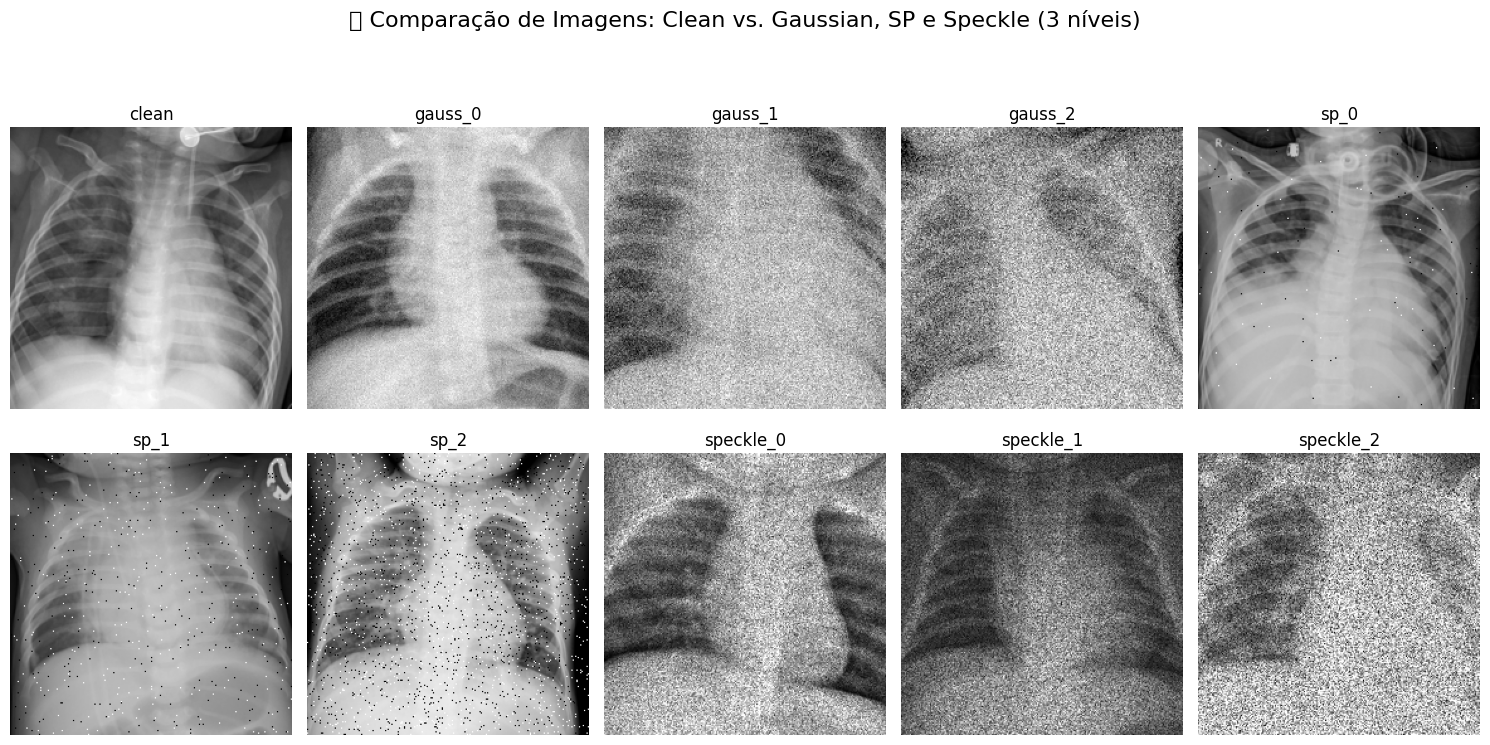

In [ ]:
#Visualizar amostra limpa em comparacao com cada tipo de ruido em intensidades

#Modalidade chest
modalidade = "chest"
base_path = Path("dataset_reduzido") / modalidade

#Subpastas
subpastas = [
    ("clean", base_path / "sem_ruido"),
    ("gauss_0", base_path / modalidade / "gauss_0"),
    ("gauss_1", base_path / modalidade / "gauss_1"),
    ("gauss_2", base_path / modalidade / "gauss_2"),
    ("sp_0", base_path / modalidade / "sp_0"),
    ("sp_1", base_path / modalidade / "sp_1"),
    ("sp_2", base_path / modalidade / "sp_2"),
    ("speckle_0", base_path / modalidade / "speckle_0"),
    ("speckle_1", base_path / modalidade / "speckle_1"),
    ("speckle_2", base_path / modalidade / "speckle_2"),
]

#Grid de demonstracao
plt.figure(figsize=(15, 8))
for i, (label, folder) in enumerate(subpastas, 1):
    arquivos = list(folder.glob("*.png"))
    if arquivos:
        img = imread(random.choice(arquivos))
        plt.subplot(2, 5, i)
        plt.imshow(img, cmap="gray")
        plt.title(label)
        plt.axis("off")

plt.suptitle("Comparacao de imagens: clean vs gaussian, sp e speckle", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
#Estruturacao dos diretorios de treino, validacao e teste

origem = Path("dataset_reduzido")
destino_base = Path("dataset_final")

#Mapeamento de cada pasta de dataset_reduzido para dataset_final
mapeamento_ruido = {
    "gauss_0": "gauss", "gauss_1": "gauss", "gauss_2": "gauss",
    "sp_0": "sp", "sp_1": "sp", "sp_2": "sp",
    "speckle_0": "speckle", "speckle_1": "speckle", "speckle_2": "speckle",
    "sem_ruido": "clean"
}

imagens_por_classe = {"gauss": [], "sp": [], "speckle": [], "clean": []}

for modalidade in origem.iterdir():
    if modalidade.is_dir():
        sem_ruido_dir = modalidade / "sem_ruido"
        if sem_ruido_dir.exists():
            imagens_por_classe["clean"].extend(sem_ruido_dir.glob("*.png"))

        ruidos_dir = modalidade / modalidade.name
        if ruidos_dir.exists():
            for subpasta in ruidos_dir.iterdir():
                tipo_ruido = mapeamento_ruido.get(subpasta.name)
                if tipo_ruido:
                    imagens_por_classe[tipo_ruido].extend(subpasta.glob("*.png"))

#Treino, validacao e teste
def dividir_lista(lista, train_ratio=0.7, val_ratio=0.15):
    random.shuffle(lista)
    n = len(lista)
    train = lista[:int(n * train_ratio)]
    val = lista[int(n * train_ratio):int(n * (train_ratio + val_ratio))]
    test = lista[int(n * (train_ratio + val_ratio)):]
    return train, val, test

#Copiar para pasta final
for classe, imagens in imagens_por_classe.items():
    train, val, test = dividir_lista(imagens)
    for split_name, split_list in zip(["train", "val", "test"], [train, val, test]):
        destino = destino_base / split_name / classe
        destino.mkdir(parents=True, exist_ok=True)
        for img_path in split_list:
            shutil.copy(img_path, destino / img_path.name)



In [ ]:
#Verificar a quantidade de amostras de cada classe em cada diretorio

import os

base_dir = "dataset_final"
splits = ["train", "val", "test"]
classes = ["clean", "gauss", "sp", "speckle"]

for split in splits:
    print(f"\n {split.upper()}:")
    for cls in classes:
        cls_dir = os.path.join(base_dir, split, cls)
        if os.path.exists(cls_dir):
            count = len([f for f in os.listdir(cls_dir) if f.endswith(".png")])
            print(f"  - {cls}: {count} imagens")
        else:
            print(f"  - {cls}: pasta não encontrada")



📁 TRAIN:
  - clean: 644 imagens
  - gauss: 890 imagens
  - sp: 887 imagens
  - speckle: 896 imagens

📁 VAL:
  - clean: 138 imagens
  - gauss: 358 imagens
  - sp: 360 imagens
  - speckle: 368 imagens

📁 TEST:
  - clean: 139 imagens
  - gauss: 369 imagens
  - sp: 347 imagens
  - speckle: 347 imagens


In [ ]:
#pre-processamento e data augmentation

base_dir = "dataset_final"

#Generator para treino
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode='constant',
    horizontal_flip=True
)

#Generator para validação/teste
test_datagen = ImageDataGenerator(rescale=1./255)

#Fluxo
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

val_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, "val"),
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3317 images belonging to 4 classes.
Found 1224 images belonging to 4 classes.


In [ ]:
#Arquitetura do modelo

def build_model():
    model = models.Sequential([
        layers.Input(shape=(224, 224, 1)),

        #Bloco 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        #Bloco 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        #Bloco 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.GlobalAveragePooling2D(),

        #Classificacao
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,572 (396.77 KB)

 Trainable params: 101,380 (396.02 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
#Treinamento com CallBacks

#Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

#Treinamento
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=50,
    callbacks=[early_stopping]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.4013 - loss: 1.2634 - val_accuracy: 0.1136 - val_loss: 1.4768
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.6417 - loss: 0.8890 - val_accuracy: 0.1127 - val_loss: 1.6018
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.7281 - loss: 0.6671 - val_accuracy: 0.2426 - val_loss: 1.5721
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.8019 - loss: 0.5102 - val_accuracy: 0.4150 - val_loss: 1.2864
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.8203 - loss: 0.4648 - val_accuracy: 0.5637 - val_loss: 0.8741
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.8414 - loss: 0.4255 - val_accuracy: 0.6691 - val_loss: 0.6847
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.8664 - loss: 0.3588 - val_accuracy: 0.7092 - val_loss: 0.6296
Epoch 8/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.8766 - loss: 0.3274 - val_accu

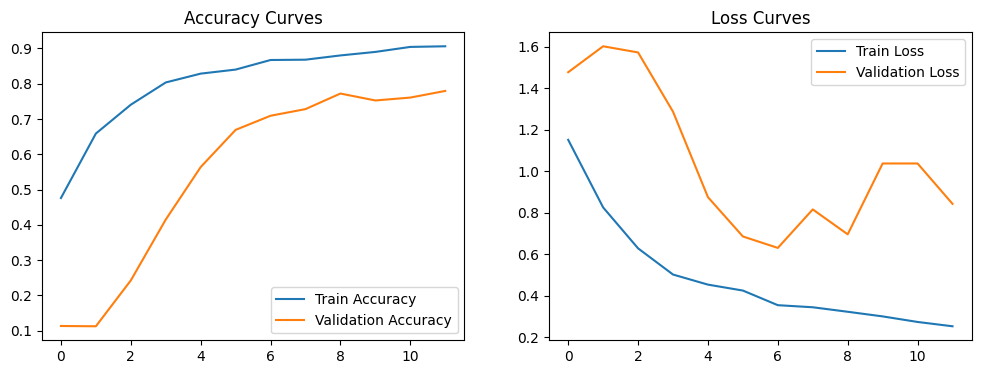

Found 1202 images belonging to 4 classes.
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - accuracy: 0.8234 - loss: 0.3818

Test Accuracy: 72.30%


In [ ]:
#Avaliacao e Visualizacao

#Plotar curvas de aprendizado
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curves')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

#Avaliar no conjunto de teste
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_generator)
print(f'\nTest Accuracy: {test_acc:.2%}')

38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 211ms/step


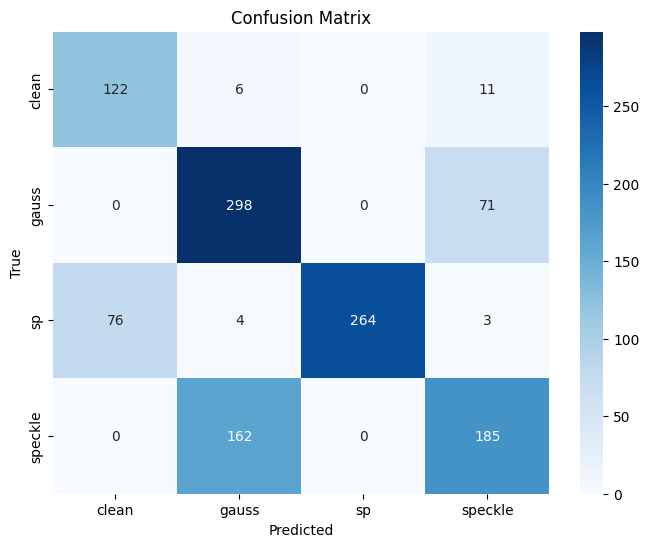

              precision    recall  f1-score   support

       clean       0.62      0.88      0.72       139
       gauss       0.63      0.81      0.71       369
          sp       1.00      0.76      0.86       347
     speckle       0.69      0.53      0.60       347

    accuracy                           0.72      1202
   macro avg       0.73      0.74      0.72      1202
weighted avg       0.75      0.72      0.72      1202



In [ ]:
#Matriz de Confusao

#Previsoes
y_true = test_generator.classes
y_pred = model.predict(test_generator).argmax(axis=1)

#Matriz de Confusao
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_generator.class_indices.keys(),
            yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#Relatorio de Classificacao
print(classification_report(y_true, y_pred, target_names=list(train_generator.class_indices.keys())))

In [ ]:
#Salvamento do modelo

model.save('medical_noise_classifier.h5')